# Word Cloud From Reddit Comments Gilded 10 Or More Times

In this notebook I'll create a word cloud visualization from words in reddit comments that were gilded at least 10 times from the beginning of reddit to February 2019. The comment texts come from the reddit dataset created and maintained by Jason Baumgartner ([/u/Stuck_In_the_Matrix](https://www.reddit.com/user/Stuck_In_the_Matrix)). The data can be queried via a web service on [Pushshift.io](https://pushshift.io/) or Felipe Hoffa's ([/u/fhoffa](https://www.reddit.com/user/fhoffa)) dataset made available on Google's Big Query service. I used the latter option running the following query, that <span style="color:#f00">processed 955 GB</span> when run 2019-04-28. 

    SELECT author, body, gilded
    FROM `fh-bigquery.reddit_comments.20*`
    WHERE gilded > 9
    
It took only a few seconds, which is impressive considering the dataset comprises several billion records, but be aware that querying the whole reddit comment dataset can become expensive quickly.

In the first code cell below, the Python libraries used in this notebook are imported, some variables set and the dataset loaded into a pandas DataFrame.

In [1]:
%matplotlib inline
%load_ext signature
import os
import re

import pandas as pd
import matplotlib.pyplot as plt
import spacy

from collections import Counter

from imageio import imread
from wordcloud import WordCloud, STOPWORDS


font = '/usr/share/fonts/truetype/ubuntu-font-family/Ubuntu-B.ttf'
limit = 1000
mask = imread('img/reddit-alien-large-mask.png')
nlp = spacy.load("en_core_web_lg")
re_non_word = re.compile(r'[\W\s]')

df = pd.read_csv(os.path.expanduser('~/data/reddit/reddit_comments_gilded_min_10_20190428.csv'))
num_comments = len(df.body)
num_comments

523

In the next step the comment texts are tokenized using the [spaCy library](https://spacy.io/) for natural language processing. Note that an English language model is used for all comments. Empty tokens and tokens recognized as stop words or which contain non-word characters except whitespace will be ignored.

Tokens identified as adverbs, interjections, nouns, verbs are lemmatized, i. e. the dictionary form is used not the inflected form. For example _is_ and _are_ are represented as a form of _be_. Adjectives and pronouns are lower-cased except for _I_ and proper names upper-cased, so they can easily be distinguished from homographs with a different part of speech.

In [2]:
names = []
words = []

for idx, text in df.body.items():
    doc = nlp(text)
    for token in doc:
        if token.is_stop or not len(token.text) or re.search(re_non_word, token.text):
            continue
        if token.pos_ in ('ADV', 'INTJ', 'NOUN', 'VERB'):
            words.append(token.lemma_)
        elif token.pos_ in ('ADJ', 'PRON'):
            if token.text in ('i', 'I'):
                words.append(token.text.upper())
            else:
                words.append(token.text.lower())
        elif token.pos_ == 'PROPN':
            name = token.text.upper()
            names.append(name)
            words.append(name)

Next we create a `Counter` object from the standard library [collections module](https://docs.python.org/3/library/collections.html) passing it the list of words to be considered for the word cloud. Then a [WordCloud](https://amueller.github.io/word_cloud/) object, setting the `mask` parameter to a black image of [Snoo](https://www.reddit.com/r/Snoo/), reddit's alien mascot. That object's `fit_words` method then gets called with the `Counter` object.

In [3]:
freq = Counter(words)
wc = WordCloud(
    max_words=limit,
    mask=mask,
    background_color='#ffffff',
    font_path=font).fit_words(freq)

Finally, we use [matplotlib](https://matplotlib.org/) to display the word cloud image in this notebook and add some explanatory text and credits to it.

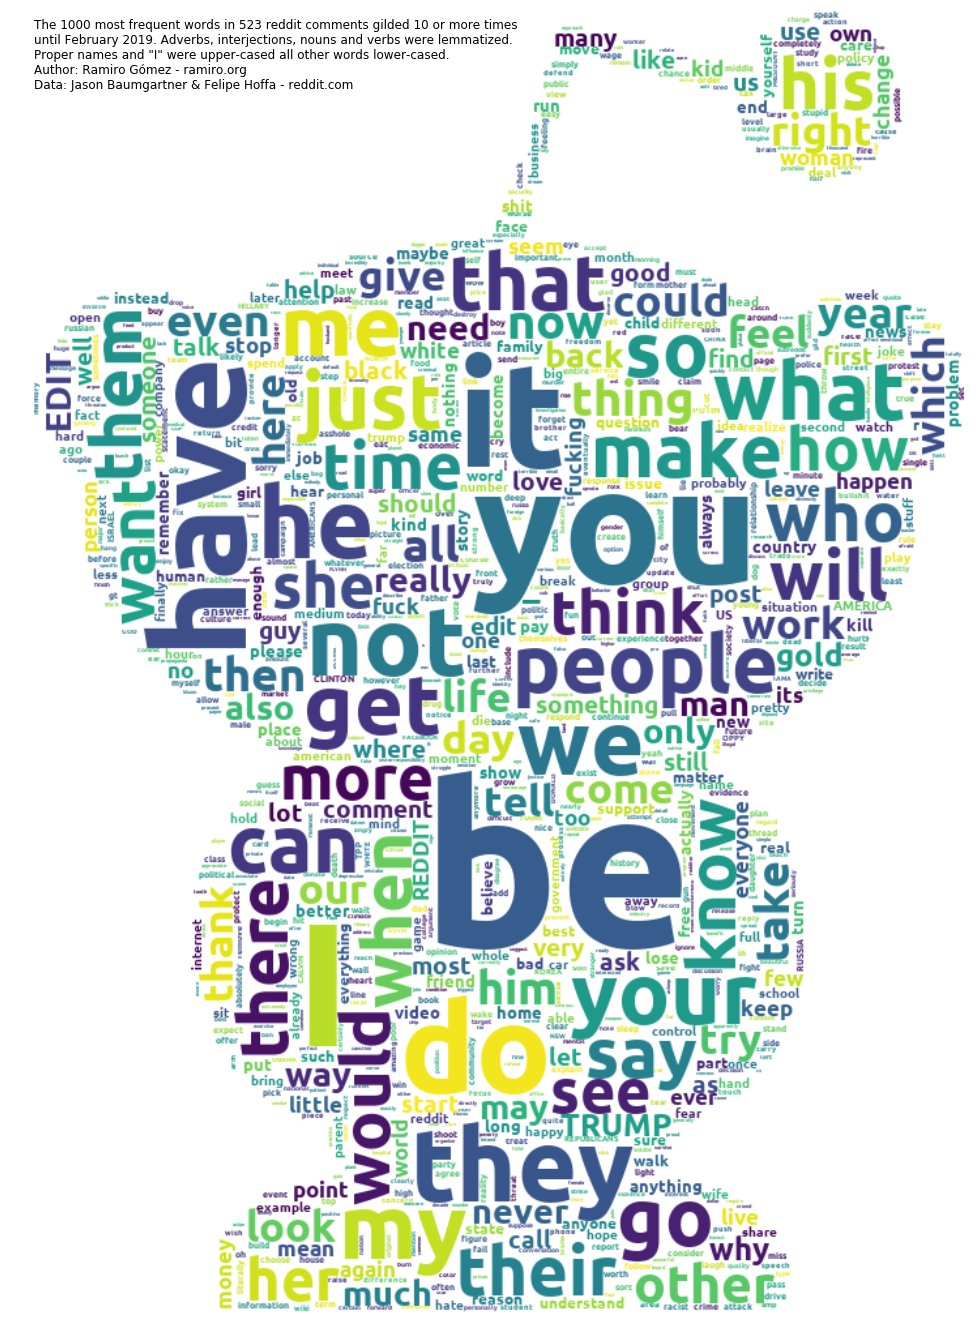

In [4]:
annotation = '''The {} most frequent words in {} reddit comments gilded 10 or more times
until February 2019. Adverbs, interjections, nouns and verbs were lemmatized.
Proper names and "I" were upper-cased all other words lower-cased.
Author: Ramiro Gómez - ramiro.org 
Data: Jason Baumgartner & Felipe Hoffa - reddit.com'''.format(limit, num_comments)

fig = plt.figure()
fig.set_figwidth(18)
fig.set_figheight(24)

plt.imshow(wc, interpolation='bilinear')
plt.annotate(annotation, xy=(0, 60), fontsize=12)
plt.axis('off')
plt.savefig('img/reddit-gilded-comments-wordcloud.png', bbox_inches='tight')

If you search for data visualization experts opinions on word clouds you'll probably come to the conclusion not to use them. There are certainly better ways to show frequencies, but I do think they have an artistic appeal and that's why I created this one.

That being said, if you are curious about which proper names occurred most often, check out the plain text output below. You can see that _EDIT_ is frequently identified as a proper name. It is often used by redditors to show they edited the comment and to explain why or just to say thanks for the gold.

In [5]:
Counter(names).most_common(10)

[('EDIT', 289),
 ('TRUMP', 275),
 ('REDDIT', 158),
 ('US', 98),
 ('AMERICA', 94),
 ('RUSSIA', 72),
 ('CLINTON', 71),
 ('PUTIN', 53),
 ('TPP', 49),
 ('ISRAEL', 49)]

In [6]:
%signature